In [1]:
import pandas as pd 
import matplotlib. pyplot as plt 
import seaborn as sns
from matplotlib import style 
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score



In [4]:
import pandas as pd

# Attempt to read the CSV file with different encodings
try:
    df = pd.read_csv("/home/luo/projects/MDD/data/multiclass/reddit mental disord.csv", encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv("/home/luo/projects/MDD/data/multiclass/reddit mental disord.csv", encoding='ISO-8859-1')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv("/home/luo/projects/MDD/data/multiclass/reddit mental disord.csv", encoding='latin1')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv("/home/luo/projects/MDD/data/multiclass/reddit mental disord.csv", encoding='utf-16')
            except UnicodeDecodeError as e:
                print("Failed to read the CSV file with different encodings.")
                raise e
            

# Display the first few rows of the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   3600 non-null   object
 1   author  3600 non-null   object
 2   date    3600 non-null   object
 3   post    3600 non-null   object
dtypes: object(4)
memory usage: 112.6+ KB


In [5]:
def data_preprocessing (text):
    if isinstance(text, float):
        text=''

    text = text.lower()
    text = re.sub(r"http\s+|www\S+http\S+", "",text,flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub("user",'',text)
    text = re.sub("url",'',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

/tmp/ipykernel_3366841/3032018702.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text = df["post"].apply(data_preprocessing)


<Axes: xlabel='Label', ylabel='count'>

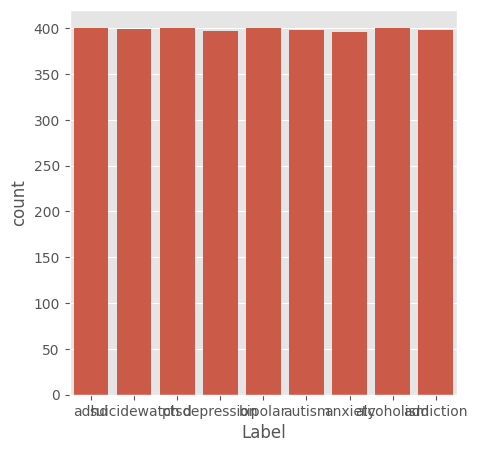

In [7]:

df.text = df["post"].apply(data_preprocessing)
df = df.drop_duplicates('post')
df['Label'].value_counts()
fig = plt.figure(figsize=(5,5))
sns.countplot(x = 'Label', data=df)

In [8]:
vect = TfidfVectorizer(ngram_range = (1,2)).fit(df['post'])
feature_names = vect.get_feature_names_out()
print('Number of features :{}\n'.format(len(feature_names)))
print('First 20 features: \n{}'.format(feature_names[:20]))

Number of features :231037

First 20 features: 
['00' '00 00' '00 07' '00 25' '00 buy' '00 every' '00 going' '00 https'
 '00 if' '00 pm' '00 when' '000' '000 000' '000 20' '000 adults'
 '000 autistic' '000 come' '000 deaths' '000 each' '000 feel']


In [9]:
X = df['post']
Y = df['Label']
X = vect.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2, random_state= 42)

x_train = x_train[y_train.notna()]
y_train = y_train.dropna()

x_test = x_test[y_test.notna()]
y_test = y_test.dropna()

print(f'size of x_train {x_train.shape}')
print(f'size of y_train {y_train.shape}')
print(f'size of x_test {x_test.shape}')
print(f'size of y_test {y_test.shape}')

size of x_train (2870, 231037)
size of y_train (2870,)
size of x_test (718, 231037)
size of y_test (718,)


In [10]:
decision_random= RandomForestClassifier()
decision_random.fit(x_train,y_train)
random_predict = decision_random.predict(x_test)
cm = classification_report(y_test,random_predict)
print(cm)

              precision    recall  f1-score   support

   addiction       0.80      0.65      0.71        79
        adhd       0.87      0.68      0.76        96
  alcoholism       0.77      0.87      0.82        70
     anxiety       0.72      0.54      0.62        81
      autism       0.69      0.80      0.74        60
     bipolar       0.77      0.66      0.71        85
  depression       0.33      0.55      0.41        78
        ptsd       0.86      0.80      0.83        87
suicidewatch       0.51      0.52      0.51        82

    accuracy                           0.67       718
   macro avg       0.70      0.68      0.68       718
weighted avg       0.71      0.67      0.68       718



Random Forest Tuning

In [11]:
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

decision_random= RandomForestClassifier()
grid_search = GridSearchCV(estimator=decision_random, param_grid=  param_grid, cv = 5)
grid_search.fit(x_train,y_train)
print ("Best Parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
cm = classification_report(y_test,y_pred)
print(cm)

Best Parameters found: {'max_depth': 30, 'n_estimators': 200}
              precision    recall  f1-score   support

   addiction       0.80      0.62      0.70        79
        adhd       0.86      0.59      0.70        96
  alcoholism       0.72      0.86      0.78        70
     anxiety       0.70      0.59      0.64        81
      autism       0.74      0.75      0.74        60
     bipolar       0.74      0.72      0.73        85
  depression       0.34      0.47      0.40        78
        ptsd       0.85      0.84      0.84        87
suicidewatch       0.54      0.67      0.60        82

    accuracy                           0.68       718
   macro avg       0.70      0.68      0.68       718
weighted avg       0.70      0.68      0.68       718

